In [1]:
EXPORT = False

# Imports and definitions

## Imports

In [23]:
import importlib
import sys
from pathlib import Path

from dotmap import DotMap

import itertools as itt
import pandas as pd
import numpy as np

import scipy.stats
import sklearn.preprocessing
import sklearn.decomposition

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


from IPython.display import display

In [32]:
path = "../../../code/"
sys.path.insert(0, path)

from plotting_config import *

In [3]:
path = "../../../code/pydea/pyDEA/"
sys.path.insert(0, path)

import pyDEA
importlib.reload(pyDEA)

<module 'pyDEA' from '/home/l10n/projects/hzm/mirna_embryo_pausing_pub/subprojects/proteomics_ivt/notebooks/../../../code/pydea/pyDEA/pyDEA.py'>

# Exporting

In [5]:
outputdir = "../results"
outputdir = Path(outputdir)

if EXPORT:
    if not outputdir.exists():
        outputdir.mkdir()
        print("created directory `{}`".format(outputdir))

# Load

In [6]:
DATASETS = DotMap()

### Misc

In [8]:
path = "../../../storage/external_resources/GRCm38_GENCODE/metadata_table_geneIDgeneName.tsv"
tbl = pd.read_table(path)
map_ENSID_geneName = tbl.set_index("gene_id")["gene_name"].to_dict()
map_geneName_ENSID = tbl.set_index("gene_name")["gene_id"].to_dict()

DATASETS['OTHER']['geneIDs']['table'] = tbl
DATASETS['OTHER']['geneIDs']['map_id_name'] = map_ENSID_geneName

display({k:v for i, (k,v) in enumerate(DATASETS['OTHER']['geneIDs']['map_id_name'].items()) if i<5})

{'ENSMUSG00000102693.1': '4933401J01Rik',
 'ENSMUSG00000064842.1': 'Gm26206',
 'ENSMUSG00000051951.5': 'Xkr4',
 'ENSMUSG00000102851.1': 'Gm18956',
 'ENSMUSG00000103377.1': 'Gm37180'}

## PROT

### Raw counts

In [9]:
path = "../../../storage/MAIN_DATA/proteomics/X_prot_noScale_noDup.tsv"
X_prot = pd.read_csv(path, header=0, index_col=0, sep="\t").T

DATASETS['PROT']['raw_cts']['path'] = path
DATASETS['PROT']['raw_cts']['table'] = X_prot

display(X_prot.head(3))
print(X_prot.shape[0])

index,E14_Pause1,E14_Pause2,E14_Pause3,E14_WT1,E14_WT2,E14_WT3
Ahnak,48816000,38734000,48325000,44185000,51647000,47314000
Dync1h1,24162000,25568000,23680000,21012000,18836000,21535000
Flna,79555000,76583000,87443000,49834000,49125000,47197000


5770


### Scaled counts

In [10]:
path = "../../../storage/MAIN_DATA/proteomics/X_prot_medScale_noDup.tsv"
X_prot = pd.read_csv(path, header=0, index_col=0, sep="\t")

DATASETS['PROT']['scaled_cts']['path'] = path
DATASETS['PROT']['scaled_cts']['table'] = X_prot

display(X_prot.head(3))
print(X_prot.shape[0])

,E14_Pause1,E14_Pause2,E14_Pause3,E14_WT1,E14_WT2,E14_WT3
Gene names,,,,,,
Ahnak,14.300864,12.780124,14.658376,14.799866,15.850174,14.289079
Dync1h1,7.078365,8.436056,7.182832,7.038017,5.780663,6.503684
Flna,23.305991,25.268246,26.524001,16.692011,15.076187,14.253745


5770


### Metadata

In [11]:
metadata_table_PROT = pd.read_csv(
    "../../../storage/MAIN_DATA/proteomics/metadata_samples.tsv",
    sep="\t",
    index_col=0
    )


map_colors = {
    "E14_Pause":"#cc5230", # Red colors,
    "E14_WT":"#00b8c1", # Cyan
}

map_marker = {1:"o", 2:"+", 3:'.'}

metadata_table_PROT["marker"] = metadata_table_PROT["replicate"].map(map_marker)

metadata_table_PROT["color"] = metadata_table_PROT["group"].map(map_colors)

display(metadata_table_PROT.head(3))

,group,replicate,marker,color
sample,,,,
E14_Pause1,E14_Pause,1,o,#cc5230
E14_Pause2,E14_Pause,2,+,#cc5230
E14_Pause3,E14_Pause,3,.,#cc5230


In [12]:
metadata_proteomics = pd.DataFrame(
    [
        ["LFQ intensity E14_WT1", "E14_WT1", None],
        ["LFQ intensity E14_WT2", "E14_WT2", None],
        ["LFQ intensity E14_WT3", "E14_WT3", None],
        ["LFQ intensity E14_Pause1", "E14_Pause1", None],
        ["LFQ intensity E14_Pause2", "E14_Pause2", None],
        ["LFQ intensity E14_Pause3", "E14_Pause3", None],
    ],
    columns=["LFQ_column", "sample", "additional_notes"],
)
map_lfq_sample = metadata_proteomics.set_index("LFQ_column")["sample"].to_dict()

In [13]:
DATASETS['PROT']['metadata']['samples'] = metadata_table_PROT
DATASETS['PROT']['metadata']['lfq_tbl'] = metadata_proteomics
DATASETS['PROT']['metadata']['map_lfq_sample'] = map_lfq_sample

### DEA

In [16]:
path = "../../../storage/MAIN_DATA/proteomics/LIMMA_diffExp/E14_Pause_VS_E14_WT_FC.tsv"
tbl = pd.read_table(path)
tbl.index = DATASETS["PROT"]["raw_cts"]["table"].index.values
tbl = tbl.rename(columns={"logFC": "logFC", "P.Value": "pval", "adj.P.Val": "padj"})

DEA_result = pyDEA.DE_results(tbl, "E14_Pause", "E14_WT", np.log2(1.5), 0.1, path=path)

DATASETS["PROT"]["DEA_limma"] = DEA_result

# Results

## PROT PCA

In [18]:
def format_projected_table_PCA(pca, X):
    PC_names = ["PC{}".format(i) for i in range(len(pca.components_))]

    PC_variance_ratio = pd.Series(pca.explained_variance_ratio_, index=PC_names)

    pca_transformed_df = pd.DataFrame(
        pca.transform(X), columns=PC_names, index=X.index.values
    )

    PC_variance_ratio = pd.Series(pca.explained_variance_ratio_, index=PC_names)

    return pca_transformed_df, PC_variance_ratio

In [19]:
def plot_PCA(
    df,
    hue,
    palette,
    style,
    PC_variance_ratio,
    title="",
    x="PC0",
    y="PC1",
    savefig_file=None,
    showplot=True,
):
    """ """
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(1, 1, 1)

    sns.scatterplot(
        data=df, x=x, y=y, hue=hue, palette=palette, style=style, s=200, ax=ax1
    )
    ax1.legend(bbox_to_anchor=(1, 1))

    ax1.set_xlabel(
        "{} ({:.1f}% variance)".format("PC0", 100 * PC_variance_ratio[x]), labelpad=20
    )
    ax1.set_ylabel(
        "{} ({:.1f}% variance)".format("PC1", 100 * PC_variance_ratio[y]), labelpad=20
    )

    ax1.set_title(title)

    # plt.tight_layout()

    # ax1.set_aspect('equal')

    if savefig_file:
        plt.savefig(savefig_file)
    if showplot:
        plt.show()

In [20]:
samples_to_group = DATASETS['PROT']['metadata']['samples']
display(samples_to_group)

,group,replicate,marker,color
sample,,,,
E14_Pause1,E14_Pause,1,o,#cc5230
E14_Pause2,E14_Pause,2,+,#cc5230
E14_Pause3,E14_Pause,3,.,#cc5230
E14_WT1,E14_WT,1,o,#00b8c1
E14_WT2,E14_WT,2,+,#00b8c1
E14_WT3,E14_WT,3,.,#00b8c1


### Raw counts

In [21]:
# raw counts
tmp = DATASETS['PROT']['raw_cts']['table']

# top 10% of variable proteins
subset = tmp.var(axis=1).sort_values(ascending=False).iloc[lambda v: range(0, int(v.shape[0]*0.1))].index.values
tmp = tmp.loc[subset,:]


title=f"raw intensities (N={tmp.shape[0]:,})"

# Create PCA object and fit to the counts
pca_prot = sklearn.decomposition.PCA()
pca_prot.fit(tmp.T)

# project samples to fit PCA.
tmp_proj, PC_variance_ratio = format_projected_table_PCA(pca_prot, tmp.T)
tmp_proj = tmp_proj.reset_index()
tmp_proj["group"] = tmp_proj["index"].map(samples_to_group["group"].to_dict().get)
tmp_proj["replicate"] = tmp_proj["index"].map(samples_to_group["replicate"].to_dict().get)
tmp_proj["symbol"] = tmp_proj["index"].map(samples_to_group['marker'].to_dict().get)

display(tmp_proj.head(3))


,index,PC0,PC1,PC2,PC3,PC4,PC5,group,replicate,symbol
0,E14_Pause1,-5.361580e+08,1.349272e+09,5.144689e+08,-2.538342e+07,3.039147e+07,5.111797e-07,E14_Pause,1,o
1,E14_Pause2,2.829102e+09,-1.740395e+08,3.011295e+07,2.604212e+08,9.723387e+07,-4.819594e-07,E14_Pause,2,+
2,E14_Pause3,6.609711e+08,4.778941e+08,-5.034098e+08,-4.203680e+08,-1.232602e+08,5.157199e-08,E14_Pause,3,.


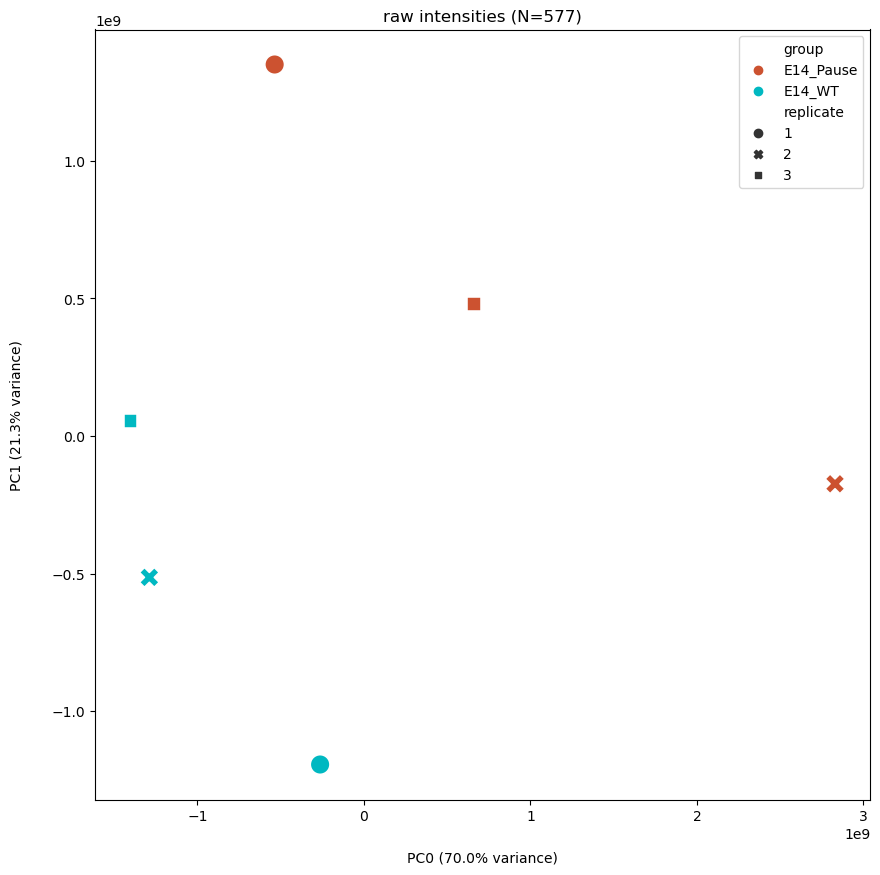

In [24]:

if EXPORT:
    savefig_file = outputdir / "PCA_raw-intensities_top-10pct-most-variable.svg"
else:
    savefig_file = None


plot_PCA(
    df=tmp_proj,
    hue="group",
    palette=samples_to_group.set_index('group')['color'].to_dict(),
    title=title,
    style="replicate",
    PC_variance_ratio=PC_variance_ratio,
    x="PC0",
    y="PC1",
    savefig_file=savefig_file
)



### Scaled

In [25]:
DATASETS['PROT']['scaled_cts']['table']

,E14_Pause1,E14_Pause2,E14_Pause3,E14_WT1,E14_WT2,E14_WT3
Gene names,,,,,,
Ahnak,14.300864,12.780124,14.658376,14.799866,15.850174,14.289079
Dync1h1,7.078365,8.436056,7.182832,7.038017,5.780663,6.503684
Flna,23.305991,25.268246,26.524001,16.692011,15.076187,14.253745
Mdn1,9.888970,13.368418,11.455524,9.458047,7.208028,8.369775
Flnb,11.482642,9.797743,10.592857,11.440965,10.922678,11.442981
...,...,...,...,...,...,...
Zik1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Znf250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Znf511,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,index,PC0,PC1,PC2,PC3,PC4,PC5,group,replicate,symbol
0,E14_Pause1,-285.355133,-397.378327,188.799014,-8.237635,11.646515,1.137979e-13,E14_Pause,1,o
1,E14_Pause2,991.213649,-34.572460,-2.161974,75.345673,29.295811,1.831313e-13,E14_Pause,2,+
2,E14_Pause3,122.015798,-225.282303,-146.588765,-131.102681,-42.976739,6.405987e-14,E14_Pause,3,.


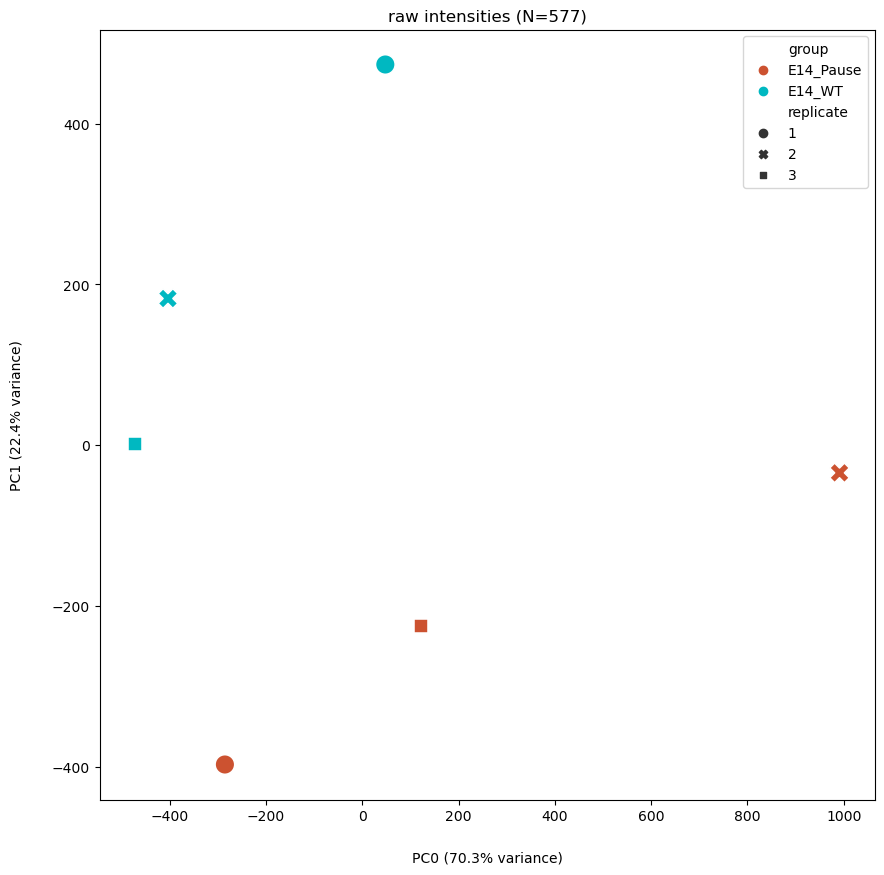

In [26]:
# scaled counts
tmp = DATASETS['PROT']['scaled_cts']['table']

# top 10% of variable proteins
subset = tmp.var(axis=1).sort_values(ascending=False).iloc[lambda v: range(0, int(v.shape[0]*0.1))].index.values
tmp = tmp.loc[subset,:]


title=f"raw intensities (N={tmp.shape[0]:,})"

# Create PCA object and fit to the counts
pca_prot = sklearn.decomposition.PCA()
pca_prot.fit(tmp.T)

# project samples to fit PCA.
tmp_proj, PC_variance_ratio = format_projected_table_PCA(pca_prot, tmp.T)
tmp_proj = tmp_proj.reset_index()
tmp_proj["group"] = tmp_proj["index"].map(samples_to_group["group"].to_dict().get)
tmp_proj["replicate"] = tmp_proj["index"].map(samples_to_group["replicate"].to_dict().get)
tmp_proj["symbol"] = tmp_proj["index"].map(samples_to_group['marker'].to_dict().get)

display(tmp_proj.head(3))


plot_PCA(tmp_proj, hue="group", palette=samples_to_group.set_index('group')['color'].to_dict(),
         title=title,
         style="replicate", PC_variance_ratio=PC_variance_ratio,
         x="PC0", y="PC1"
        )



## Correlation between replicates

In [27]:
samples_to_group

,group,replicate,marker,color
sample,,,,
E14_Pause1,E14_Pause,1,o,#cc5230
E14_Pause2,E14_Pause,2,+,#cc5230
E14_Pause3,E14_Pause,3,.,#cc5230
E14_WT1,E14_WT,1,o,#00b8c1
E14_WT2,E14_WT,2,+,#00b8c1
E14_WT3,E14_WT,3,.,#00b8c1


In [28]:
column_pairs = list(
    itt.chain(
        *(
            itt.combinations(
                DATASETS["PROT"]["raw_cts"]["table"].filter(regex=c).columns, 2
            )
            for c in samples_to_group["group"].unique()
        )
    )
)

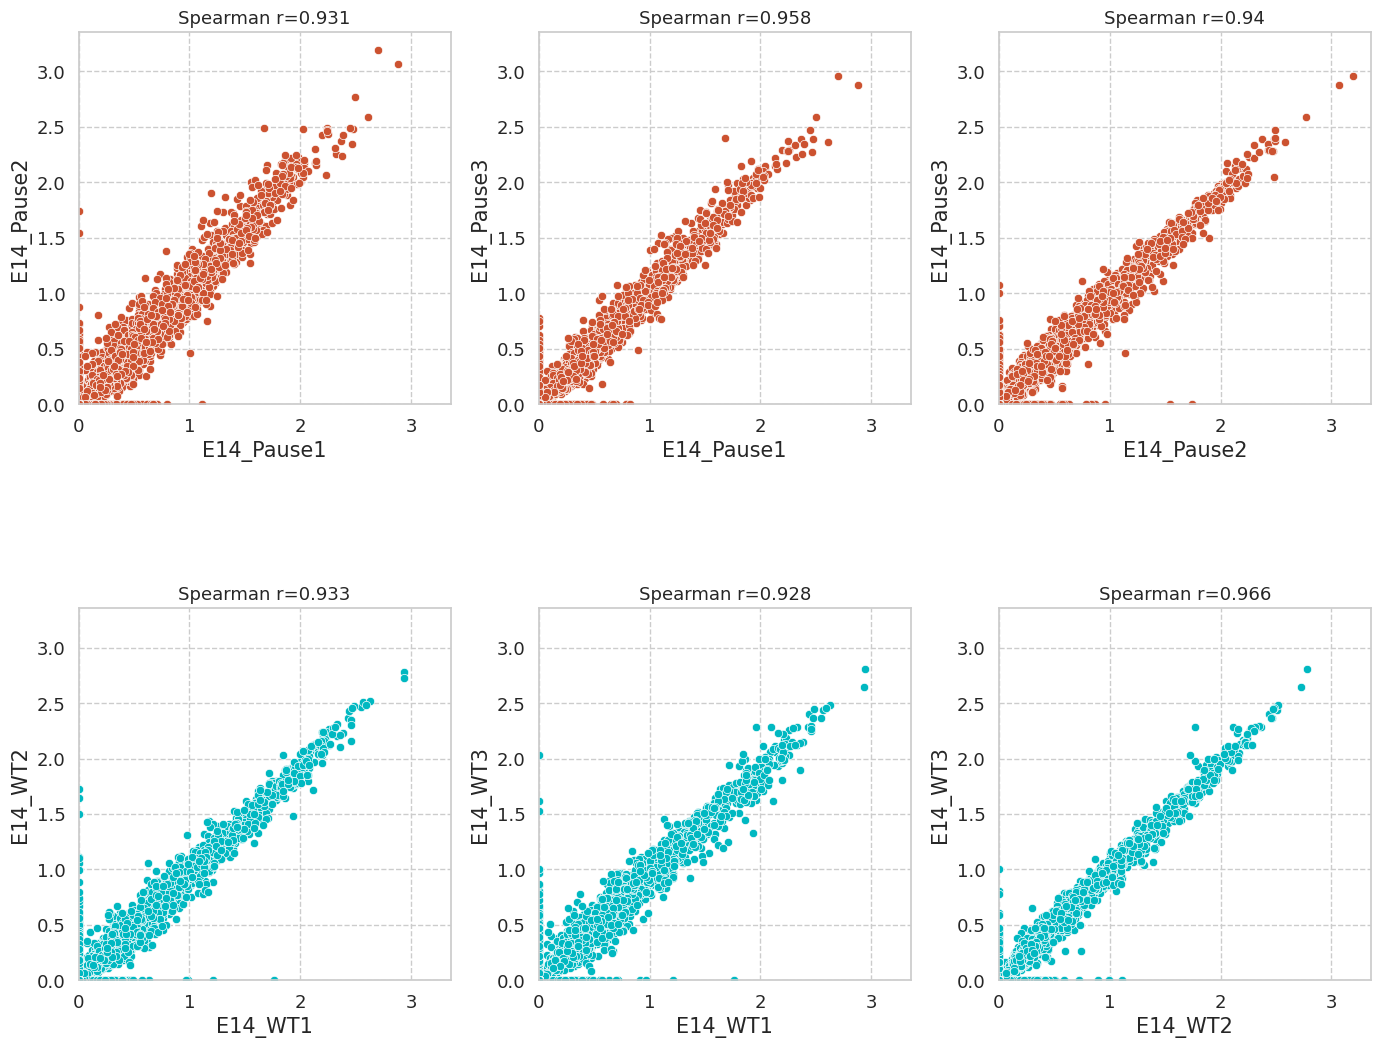

In [35]:
# Showing correlation of raw intensities between replicates
# of each group

if EXPORT:
    savefig_file = outputdir / "correlation-raw-intensities-replicates.svg"
else:
    savefig_file = None


tmp = DATASETS["PROT"]["scaled_cts"]["table"].applymap(lambda v: np.log10(v + 1))

fig, axs = create_regular_grid_axes(
    N_tot=len(column_pairs), N_cols=3, height_row=6, width=14
)

for i, c_pair in enumerate(column_pairs):
    ax = axs[i]
    group = c_pair[0][:-1]
    sns.scatterplot(
        data=tmp,
        x=c_pair[0],
        y=c_pair[1],
        color=samples_to_group.set_index("group")["color"].to_dict()[group],
        ax=ax,
    )
    ax.set_xlabel(c_pair[0])
    ax.set_ylabel(c_pair[1])
    ax.set_xlim(min(0, tmp.min().min()), tmp.max().max() * 1.05)
    ax.set_ylim(min(0, tmp.min().min()), tmp.max().max() * 1.05)

    r, p = scipy.stats.spearmanr(tmp[c_pair[0]], tmp[c_pair[1]])

    ax.set_title(f"Spearman r={r:.3}")


_ = [ax.set_aspect("equal") for ax in axs]

if savefig_file is not None:
    plt.savefig(savefig_file)

plt.show()

## PROT DEA

In [36]:
DATASETS['PROT']['DEA_limma']

DE experiment : E14_Pause vs E14_WT with thresholds pVal≤0.1 and |LFC|≥0.5849625007211562

Number of genes: 5,770 of which 457 are DE
* notSign: 4,799
* belowThreshLFC: 514
* UP: 216
* DOWN: 241

In [37]:
dea = DATASETS['PROT']['DEA_limma']

In [38]:
dea.get_significant().assign(abs_logFC=lambda df: df['logFC'].abs()).sort_values('abs_logFC', ascending=False
                                                                                ).loc[lambda df: df['DE_status']=='UP']

,logFC,pval,padj,AveExpr,t,B,DE_status,abs_logFC
Tubb5,2.540289,0.000366,0.011537,5.483452,8.401233,0.878911,UP,2.540289
Mdn1,2.249678,0.000002,0.002157,6.946685,24.626952,6.146657,UP,2.249678
Paics,1.973190,0.001076,0.019222,6.578011,6.681495,-0.681468,UP,1.973190
Thrap3,1.950920,0.003244,0.036393,5.252272,5.231687,-1.509062,UP,1.950920
Fubp3,1.945721,0.000357,0.011537,4.812846,8.445063,0.937543,UP,1.945721
...,...,...,...,...,...,...,...,...
Wars,0.593884,0.012145,0.082446,7.645907,3.813015,-3.503319,UP,0.593884
Ago2,0.591474,0.002197,0.028950,4.242734,5.712457,-0.903613,UP,0.591474
Cnn3,0.588396,0.016359,0.098618,4.290693,3.530294,-3.084104,UP,0.588396
Smg1,0.587471,0.015100,0.093986,4.432209,3.605180,-3.045516,UP,0.587471


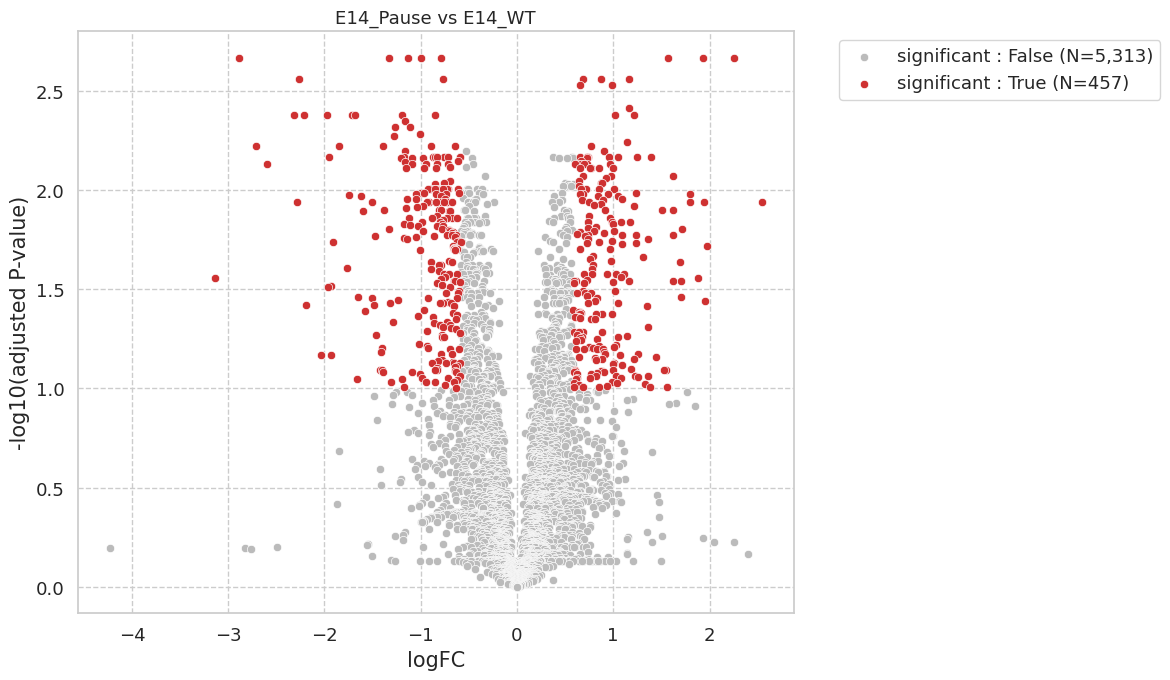

In [39]:
DATASETS['PROT']['DEA_limma'].volcano_plot()

# EXPORT SUPP TABLE

Export an excel file with :

- quantification
- filtered quantification
- DEA results

In [40]:
path = "../../../storage/MAIN_DATA/proteomics/mouse proteinGroups.tsv"
tmp_full_dataset = pd.read_csv(path, header=0, index_col=None, sep="\t")

In [41]:
tmp_full_dataset.shape[0]

6223

In [42]:
dea.get_full_table().shape[0]

5770

In [43]:
path = outputdir / "SupplementaryTable_S6_proteomics_quantification-and-dea.xlsx"

if EXPORT:
    with pd.ExcelWriter(path, date_format=None, mode='w') as out_obj:

        #
        tmp_full_dataset.to_excel(
            out_obj,
            sheet_name="MaxQuant_results",
            index=False,
            header=True,
            )

        # Filtered proteins, no transformation
        # Columns = ['index',] + list_samples
        tmp = DATASETS['PROT']['raw_cts']['table']
        tmp.to_excel(
            out_obj,
            sheet_name="Filtered raw intensities",
            index=True,
            header=True,
        )

        dea_tbl = DATASETS['PROT']['DEA_limma'].get_full_table()
        dea_tbl.to_excel(
            out_obj,
            sheet_name="DEA results",
            index=True,
            header=True,
        )


